# *Last part of the extension :*
In this notebook, we will study friends meetings  patterns

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime as dt

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
def calculate_distance (lat1, lon1, lat2, lon2):
    """
    ############ Function we used in P2 and P4 (individual) to calculte distances ##########

    R : radius of earth : 6378.137 km
    lat1,lon1 : latitude and longitude of one user
    lat2,lon2 : latitude and longitude of other user
    """
    R = 6378.137
    # convert into radians
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    #get difference of lattitude and difference of longitude
    delta_lat = lat2_rad-lat1_rad
    delta_lon = lon2_rad-lon1_rad
    
    #return formula Haversine formula
    a = ((np.sin(0.5 * delta_lat)) ** 2) + np.cos(lat1_rad) * np.cos(lat2_rad) *\
                                            ((np.sin(0.5 * delta_lon)) ** 2)
    return 2 * R * np.arcsin(np.sqrt(a))

In [3]:
def drop_inf_na(df):
    """
    drops +inf , -inf , nan values from dataset
    """
    df.replace ([np.inf, -np.inf], np.nan)
    return df.dropna()

### **Import datasets paths** : 
- We will use them in the future function .
- We import them in the future funcions in order to preserve memory

In [64]:
#Venues path
VENUES_PATH = os.path.join('data', 'raw_POIs.txt')

#We will import the checkins dataframe later in our work.
CHECKINS_PATH = os.path.join('data', 'dataset_WWW_Checkins_anonymized.txt')

#Import friendship paths
FRIENDSHIPS_PATH = os.path.join('data', 'dataset_WWW_friendship_new.txt')

#If the dataset is already saved, we can choose to just upload it
FOURSQUARE_PATH = os.path.join('data', 'foursquare_checkin_data.csv.zip')

####  Prepare initial dataset : 
- In order to preserve memory, we work with chunks of size 5x10**5.
- In the new proceeded dataset we will create, we want to have both the user Id and the place where he checked in, as well as its locations.
- We will also take the day into a separate column (we will need it in the future).
- Finally, we will build a column that takes the format datetime (we will also need this column in the future)

## **2) Friends checkins:**


- We want to find checkin patterns between friends gaherings.
- For that, we create a new dataframe, with whome we are are going to work for this whole part.
- We assume two friends have met together if they have checked in the same place with at most one hour difference. Since our dataframe is labeled and each place has its own id, we don't need to do any approximation on the checkin distance between friends.


In [5]:
def get_initial_df (VENUES_PATH, CHECKINS_PATH, save_initial_df=False):
    """
    function used to create the foursquare complete checkin data 
    
    The file will contain the columns :
    ['User_ID','Venue_ID',local_time','day','lat','lon','country']
    
    """
    #Import venues dataset
    venues = pd.read_csv(VENUES_PATH, sep='\t', encoding='latin-1',\
                         names=['Venue_ID', 'lat', 'lon', 'place', 'country'], header=None)

    chunksize = 5*10 ** 6
    #df : dataframe to be returned
    df = pd.DataFrame()

    for chunk in pd.read_csv(CHECKINS_PATH, chunksize=chunksize, sep='\t',\
           names=['User_ID','Venue_ID','UTC_time','hour'], header=None):
        chunk = drop_inf_na(chunk)
        chunk['day'] = chunk['UTC_time'].str.split(" ",expand=True).dropna(how='any')[0]
        chunk['local_time'] = (pd.to_datetime(chunk["UTC_time"],errors='coerce') + chunk['hour'].\
                               apply(lambda x: dt.timedelta(minutes =x))).dropna(how='any') 
        
        df = df.append(chunk.drop(axis=1, columns=['UTC_time', 'hour']).\
                       merge(venues), ignore_index=True)
    if save_initial_df : df.to_csv('foursquare_checkin_data.csv.zip', compression='zip')
    return df

In [6]:
def friends_gatherings(import_ready_file, FRIENDSHIPS_PATH, FOURSQUARE_PATH=None,\
                       VENUES_PATH=None, CHECKINS_PATH=None, save_initial_df=True):
    """
    function to get dataframe where friends gathered
    INPUTS : 
        - import ready_file : boolean : Whether the user wants to import the already 
        preprocessed file or if he wants to generate it himself
        - FRIENDSHIPS_PATH : friendships (edges) path
        - FOURSQUARE_PATH : path of the preproceeded file (if the user just wants to load it)
        This parameter is ignored if the user chooses to generate the file himself again
        - VENUES_PATH : path for venues dataframe
        This parameter is ignored if the user chooses to just import the preprocessed file
        - CHECKINS_PATH : path for checkins dataframe
        This parameter is ignored if the user chooses to just import the preprocessed file
        - save_initial_df : if the user chooses to run the file again, he can choose to 
        download the proceeded dataframe
        
    OUTPUTS :
        - dataframe that will be used for 1 futur plot, contains two columns : 
        distance from home and probability of checkin
        This dataframe isn't limited to friends checkins and is used to see 
        if there is any difference between considering friends gatherings or not
        
        - Friends dataframe : contains the dataframe that will be used all this part for our studies.
    This dataframe contains the columns :
    ['User ID','Venue ID','day','local time','lat','lon','place','country']

    ** In order to have a study that is the most accurate possible, 
    we only work on users that checked in their homes at least once.
    That helps us make no approximation on the home location. 
    Moreover, our dataframe being large, 
    we don't have the problem of not having enough data to study.

    ** In order to preserve memory, we will import the friendship dataframe in this function, 
    we won't need it after that.
    """
    
    #Import two datasets
    if import_ready_file : 
        if FOURSQUARE_PATH is None :
            raise ValueError ("You need to specify the path from where you want to import \
            the data ('FOURSQUARE_PATH')")
        df = pd.read_csv(FOURSQUARE_PATH, parse_dates=['local_time'], compression='zip')
        
    else:
        if VENUES_PATH is None or CHECKINS_PATH is None:
            raise ValueError ("You need to specify the path from where you want to import \
            the data ('VENUES_PATH','CHECKINS_PATH')") 
        df = get_initial_df (VENUES_PATH, CHECKINS_PATH, save_initial_df=False)
    
    friendships = pd.read_csv(FRIENDSHIPS_PATH, sep='\t', encoding='latin-1',\
                              names=['User_ID','User2_ID'], header=None)

    #clean edges dataframe : erase columns where the person following 
    #and the person followed are the same
    friendships = friendships[friendships['User_ID'] != friendships['User2_ID']]

    #create a new dataframe : df1 : used to find the home location of each user 
    #To do that,  we keep only the line where the user checked in their homes
    #Then, we get the means of checkin latitude and longitude for each user 
    #and each place checked in to find the home location
    # ==> The home location is the mean of checkins that were in the home of a user
    # We finally return only the three columns needed to perform the final merge to have the final 

    #We just initialize the two columns we need
    df1 = df[['User_ID', 'lat', 'lon', 'place']].rename(columns={'lat':'home_lat','lon':'home_lon'})
    df1 = df1.groupby(['User_ID', 'place'], as_index=False).\
        agg({'home_lat':'mean', 'home_lon':'mean'}, axis='columns')
    df1 = df1[df1['place'].str.contains('Home (private)', regex=False)][['User_ID','home_lat','home_lon']]
    #df1 now contains for each user his home longitude and home latitude

    #We then perform a merge with the original dataset to integrate the home coordinates to the dataset
    df1 = df1.merge(df[['User_ID','Venue_ID','day','local_time','lat','lon','place','country']])
    df1['dist_home'] = calculate_distance(df1['lat'], df1['lon'], df1['home_lat'], df1['home_lon']).\
                        round()
    
    #Now we move to finding the final dataframe (the one we will use in the future)
    merged_friends = pd.DataFrame()
    chunksize = 5*10**6
    numb_chunks = int(np.ceil(df1.shape[0]/chunksize))
    #We work with chunks of size 10**6 each
    for i in range(numb_chunks):
        # Since we want the checkin place to be exactly the same for each user (have the same id),
        #we perform the merge on both the user and his checkin place 
        #(this procedure helped us save much memory and time)
        tmp_merge = df1[chunksize*i:chunksize*(i+1)].merge(friendships).\
                    merge(df1[['User_ID', 'Venue_ID', 'local_time']],\
                          left_on=['User2_ID', 'Venue_ID'], right_on=['User_ID','Venue_ID']).\
                    rename(columns={'dist_home_x':'dist_home'})

        #filter the tmp_merge with friends that checked in at most with 
        #one hour difference in the same place
        tmp_merge = tmp_merge[(np.abs((tmp_merge['local_time_x'] - tmp_merge['local_time_y']).\
                                      dt.total_seconds())<3600)]
        tmp_merge = tmp_merge.rename(columns={'local_time_x':'local_time'})

        #append the chunk to the final dataset
        merged_friends = merged_friends.append(tmp_merge[['day','local_time','place', 'country',\
                                                          'dist_home']], ignore_index=True)
        
    return get_vects_plot(df1[['dist_home']]), merged_friends

In [7]:
def get_vects_plot(df):
    """
    function to calculate the probability of checkin as a function of the distance
    Returns a dataframe where there are two columns: the distance from home and its probiability

    We begin by counting the number of checkin for each distance
    The we divide by the total number of counts to get a  probability.
    """
    #Create a new column, we will change it after
    #This new column will contain the probability of probability of checking in knowing the distance from home
    df1 = df.copy()
    df1['proba_dist'] = df1['dist_home']
    
    #'proba dist' column now contains the number of checkins for each distance
    df1 = df1.groupby('dist_home', as_index=False).count()[['dist_home','proba_dist']]

    #We divide the 'proba dist' column by the total number of checkins
    df1.loc[:,'proba_dist'] = df1['proba_dist'] / df1['proba_dist'].sum()
    return df1[['dist_home', 'proba_dist']]

In [8]:
df_tot, df_friends = friends_gatherings(import_ready_file=True, FRIENDSHIPS_PATH=FRIENDSHIPS_PATH,\
                                     FOURSQUARE_PATH=FOURSQUARE_PATH)

In [9]:
df_friends.head(2)

,day,local_time,place,country,dist_home
0,Sat,2012-05-05 19:24:41+00:00,Bar,US,161.0
1,Fri,2012-05-04 16:45:44+00:00,Airport,US,18.0


In [11]:
def power_func(x, a, b):
    """
    function to compute a*(x^b)
    This function will be used to fit a power law to the distribution of distance from home checkins
    """
    return a * np.power(x,b)


In [12]:
#df_plot_friends : dataframe used for the plot below
df_plot_friends = get_vects_plot(df_friends)

In [13]:
df_plot_friends.head(2)

,dist_home,proba_dist
0,0.0,0.026705
1,1.0,0.081007


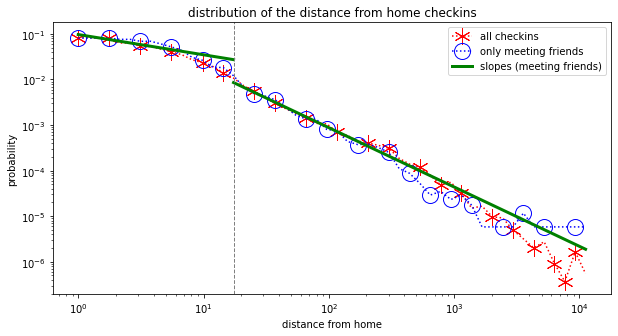

In [65]:
#The change_point isthe point where the behavior of the curves changes
#We find the chnge point empirically
change_point = 16
#We create a logspace x_axis, we will use this vector for our futur plots
x_log = np.logspace(0,4.05,50)

#For both dataframes, we do an interpolation to find the corresponding values in the new logspace axis
#First, we begin by finding the interpolation functions for each vector,
#Then, we apply them of the dataframes
f_friends = interp1d(df_plot_friends['dist_home'], df_plot_friends['proba_dist'], kind='zero')
f_tot = interp1d(df_tot['dist_home'], df_tot['proba_dist'], kind='zero')

#y_friends,y_tot will be the vectors used for the plot.
#We don't apply the  median because we want to see the true curve, not a smoothed one.
y_friends = f_friends(x_log)
y_tot = f_tot(x_log)

#Since we want to approximate the parameters of our curves, we use scipy function 'fit_curve' 
#'params_friends1' are parameters for smaller distnces
#'params_friends2' are parameters for bigger distances
params_friends1,_ = curve_fit(power_func, x_log[:change_point], y_friends[:change_point])
params_friends2,_ = curve_fit(power_func, x_log[change_point:], y_friends[change_point:])

plt.figure(figsize=(10,5))
#Create marker style for both vectors and do the plots
#Plot all checkins
marker_style_all = dict(color='r', linestyle=':', marker=(6, 2, 0), markersize=16)
plt.loglog(x_log,y_tot, markevery=0.05, **marker_style_all, label='all checkins')

#Plot checkins proceeded only with friends
marker_style_friends = dict(color='blue', linestyle=':', marker='o', markersize=16, fillstyle='none')
plt.loglog(x_log, y_friends, markevery=0.05, **marker_style_friends, label='only meeting friends')
plt.xlabel('distance from home')
plt.ylabel('probability')
plt.title('distribution of the distance from home checkins')

#Now we proceed the plot of the approximation curve for smaller and larger distances
plt.loglog(x_log[change_point-1:], power_func(x_log[change_point-1:], params_friends2[0],\
                                              params_friends2[1]),\
                  color='g', linewidth=3, label='slopes (meeting friends)')

plt.loglog(x_log[:change_point], power_func(x_log[:change_point], params_friends1[0],\
                                            params_friends1[1]),\
                  color='g',linewidth=3)

plt.axvline(x_log[change_point-1], linestyle='--', linewidth=1, color='grey')
#plt.xticks([change_point+1],[round(x_log[change_point-1],0)])
plt.legend()

In [68]:
print('we have slopes of {} for distances inferior to 30km\nand slopes of {} \
for distances superior to 20km'.\
      format(round(params_friends1[1],2), round(params_friends2[1],2)))

we have slopes of -0.44 for distances inferior to 30km
and slopes of -1.3 for distances superior to 20km


In [53]:
print('For distances inferior to 20km:\nThe distribution checkins knowing the distance',
      'from home can ba approximates as :\nP(x)={}*exp({}*x)'.\
      format(round(params_friends1[0], 2), round(params_friends1[1],2)))

print('\nFor distances superior to 20km:\nthe distribution checkins knowing the distance',
    'from home can ba approximates as :\nP(x)={}*exp({}*x)'.\
      format(round(params_friends2[0],2),round(params_friends2[1],2)))

For distances inferior to 20km:
The distribution checkins knowing the distance from home can ba approximates as :
P(x)=0.1*exp(-0.44*x)

For distances superior to 20km:
the distribution checkins knowing the distance from home can ba approximates as :
P(x)=0.35*exp(-1.3*x)


- We can also approximate the probability of moving from home knowing the distance with two equations:

$$ P(x)=
\begin{cases}
    0.1e^{-0.44x} & \text{if x<20 km}\\
    0.35e^{-1.3x} & \text{otherwise}
\end{cases}
$$

- We notice a change in the slope at a distance of approximately 20km distance from home. This behavior is similar to the one described in the paper. However, some differences are noticeble:  
1) The shift happened in a distance of 20km from home (vs 100km using other daasets)  
2) The slope are different than the ones described in the paper.  
Firstly, the slopes generally are smaller in our study compared to the ones found in the paper.  
Secondly, while the slope is smaller for small distances in the paper (-1.9 < -0.9), the behaviour is different in our study (-0.44 > -1.3)

- Finally, we notice in the plots that whether a user visited a friend or not does not make much differences in the overall behavior of checkins. We make the hypothesis that the behavior is the same and we test it. This hypothesis states that friends don't have any influence on a user's movement.
- Before going into that, we test whether our data is normally distributed or not. We perform a Kolmogorov Smirnov test, a test made to check whether a distribution is normal or not. The  Null hypothesis is that the sample comes from a normal distribution. and we reject it depending on the pvalue we get. The p-value is the probability of obtaining results that aren't more extereme than the ones observed, if we assume the null hypothesis is true.


In [56]:
from statsmodels.stats import diagnostic 
_, p_value_friends = diagnostic.kstest_normal(df_plot_friends['proba_dist'], dist='norm')
_, p_value_tot = diagnostic.kstest_normal(df_tot['proba_dist'], dist='norm')

In [62]:

print('Having the Null hypothesis that the data is derived from a normal distribution,we get\
:\n \t pvalue {} for the total checkins \n \t pvalue {} for the checkins with only friends'.\
      format(round(p_value_tot,4),round(p_value_friends,4)))

Having the Null hypothesis that the data is derived from a normal distribution,we get:
 	 pvalue 0.001 for the total checkins 
 	 pvalue 0.001 for the checkins with only friends


In [54]:
print('The dataframe containing only checkins with friends contains {} ligns\n',
    'The dataframe containing all checkins contains {} ligns'.\
      format(df_plot_friends.shape[0],df_tot.shape[0]))

The dataframe containing only checkins with friends contains {} ligns
 The dataframe containing all checkins contains 3249 ligns


$\Rightarrow$ Using the result found before, we conclude our data is not derived from a normal distribution

- Now we test whether the behaviour is the same or not for the two sets (considering all checkins vs considering only checkins with friends). This will help us know whether friends do have an influence on people's movement or not.
- We use the assertions below:  
1) We took two different samples from the same population.  
2) The data we're treating (probabilities) is not derived from a normal disrtibution (verified).  
3) Our samples are paired since they are derived from the same dataset  
$\Rightarrow$  We do a Wilcoxon test.  
To test the null hypothesis that there is no difference in behavior, we can apply the two-sided test.

- Our frames being of different shapes, we create a vector that will be used to make to comparision between the two frames and we use interpolations in order to have the the most precise values possible. 


In [20]:
x_log_exp=np.logspace(0,4.05,3000)

#For both dataframes, we do an interpolation to find the corresponding values in the new logspace axis
#First, we begin by finding the interpolation functions for each vector,
#Then, we apply them of the dataframes
f_friends_exp = interp1d(df_plot_friends['dist_home'], df_plot_friends['proba_dist'], kind='zero')
f_tot_exp = interp1d(df_tot['dist_home'], df_tot['proba_dist'], kind='zero')

#y_friends_exp,y_tot_exp will be the expanded (working with 3000 points) vectors used for the hypothesis testing
y_friends_exp = f_friends_exp(x_log)
y_tot_exp = f_tot_exp(x_log)

In [21]:
from scipy.stats import wilcoxon

In [63]:
_, p_value = wilcoxon(np.abs(y_friends_exp - y_tot_exp))
print('The pvalue found after performing a wilcoxon test is :', np.round(p_value, 4))

The pvalue found after performing a wilcoxon test is : 0.0


- Having found a p-value of 0.0, we strongly reject our Null hypothesis.  
$\Rightarrow$ We conclude that friends do have a significant importance on a user's mobility. 

## **3) Places checkin patterns**
### I) Preprocessing :
- From now on, we only work with checkins with friends only : Every thing we will be studying are meetings between friends.
- We now go through our dataset and gategorize our places features into different categories:  
1) `Eat` : Going to eat with friends (restaurant , fast food ...)  
2) `Study` : Studying (being in school, universty ...)  
3) `Drink` : Having a drink with friends, going out ...  
4) `Culture` : Going to watch a movie, visit monuments ...  
5) `Home` : meet at someone's home  
6) `Move` : take public transports or travel to far places  
7) `Consume` : Visit stores, malls ...  
8) `Work` : Being in work's place  
9) `Entertain` : Go to a spa, hotel, beach,park ...  
10) `Sport` : practise sports together  

- We also categorize the days of the week into two types:  
1) `Working days` : Monday until Friday  
2) `Week end day` : Saturday and Sunday  

### II) Processing :
- We study the probability people meet in each category
- We compare normalized probabilities




In [34]:
df_classified = df_friends.copy()

#Change the name of variables to its type (will be used after)
df_classified.loc[df_classified['place'].str.\
                  contains('restaurant|Burger|pizza|Diner|food|Steakhouse|\
                  BBQ|Dessert|Ramen|Ice Cream|Fried|Sandwich|breakfast|snack|\
                  taco|hot|soup|wings', case=False), 'place'] = 'Eat'

df_classified.loc[df_classified['place'].str.\
                  contains('college|University|school|student', case=False), 'place'] = 'Study'

df_classified.loc[df_classified['place'].str.\
                  contains('coffee|Bar|Nightclub|pub|Lounge|Beer|tea|Nightlife',\
                           case=False), 'place'] = 'Drink'

df_classified.loc[df_classified['place'].str.\
                  contains('multiplex|Movie|Theater|concert|Music|historic|arts|\
                  Museum|library|Monument|temple|art',case=False), 'place'] = 'Culture'

df_classified.loc[df_classified['place'].str.\
                  contains('Home|Residential|Building',case=False), 'place'] = 'Home'

df_classified.loc[df_classified['place'].str.\
                  contains('station|airport|subway|travel|boat|bus', case=False),'place'] = 'Move'

df_classified.loc[df_classified['place'].str.\
                  contains('store|mall|plaza|shop|boutique|market', case=False),'place'] = 'Consume'

df_classified.loc[df_classified['place'].str.\
                  contains('work|office|Startup|professional', case=False), 'place'] = 'Work'

df_classified.loc[df_classified['place'].str.\
                  contains('soccer stadium|Entertainment|Outdoor|beach|park|event|\
                  Arcade|resort|hotel|spa|Casino',case=False),'place'] = 'Entertainement'

df_classified.loc[df_classified['place'].str.\
                  contains('soccer field|sport|gym|stadium|surf|pool|golf|\baseball',\
                           case=False), 'place'] = 'Sport'

#Change the name of a day to its type (work day or week end)
df_classified.loc[df_classified['day'].str.contains('mon|tue|wed|thu|fri', case=False), 'day'] = 'Work day'
df_classified.loc[df_classified['day'].str.contains('sat|sun', case=False), 'day'] = 'Week end'

#Keep only the place types we mentioned before 
df_classified = df_classified.loc[df_classified['place'].str.\
    contains('sport|Entertainement|Work|Consume|Move|Home|Culture|Drink|Study|Eat', case=False),:]

df_places = df_classified.groupby(['place', 'day'], as_index=False).agg({'country':'size'}).\
                sort_values(by='country', ascending=False)[['place','day', 'country']].\
                rename(columns={'country':'numb_checkins', 'place':'place_type', 'day':'day_type'})


In [35]:
df_classified.head(2)

,day,local_time,place,country,dist_home
0,Week end,2012-05-05 19:24:41+00:00,Drink,US,161.0
1,Work day,2012-05-04 16:45:44+00:00,Move,US,18.0


In [36]:
df_places.head(2)

,place_type,day_type,numb_checkins
17,Study,Work day,41063
7,Eat,Work day,16859


- Now we move to visualizing the distributions :

Text(0.5, 1.0, 'meeting patterns between friends')

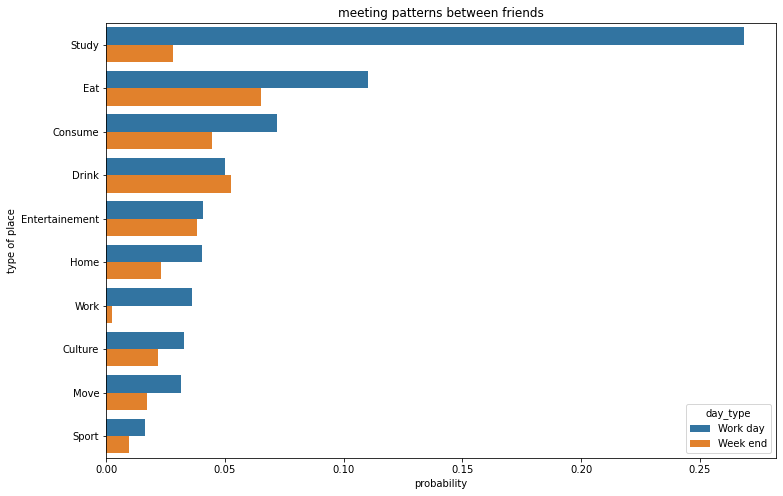

In [37]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_places['numb_checkins'] / df_places['numb_checkins'].sum(),\
            y=df_places['place_type'], orient='h', hue=df_places['day_type'])
plt.xlabel('probability')
plt.ylabel('type of place')
plt.title('meeting patterns between friends')

- The visualization above shows us that people are the most likely to be studying. This observation can be explained by the fact that students are the most likely to use sociaal media, so the most number of checkins can be found among students.
- However, we can't draw more conlusions because we have to take into account that there are 5 work days and 2 week end days in a week. $\rightarrow$ In order to be able to compare and study people's checkins, we normalize by the number of days each probability.  
- We will :  
1) Divide each probability that any event occured in a working day by 5  
2) Divide each probability that any event occured in a week end day by 2  
3) Get the normalized difference (normalized probability that a user checks in in a working day - normalized probability that a user checks in in a week end day)  
4) Divide the result by the probability of occurence in a work day to have a ratio.  
The final equation we will have is (for each place):
$$
final ratio = \frac{\frac{P_{workday}}{5}-\frac{P_{workend}}{2}}{\frac{P_{weekday}}{5}}
$$

- In the end:  
1)If this difference is positive : people are more likely to checkin in the place in a working day  
2)If this difference is negative : people are more likely to checkin in the place in a week end day  
3)The absolute value gives us the magnitude of the absolute ratio


In [38]:
def ratio (x):
    """
    Function to get difference between items atn then normalize
    Since x contains one negative (week end) and one positive (work day) value,
    max(x) is the value  of probability for a working day
    """
    return sum(x) / max(x)

In [39]:
#df4=df_classified.copy()
#normalize to have proba/day and then take the difference between the items:

#First, we divide by the number of days and set week end probabilities to be negative values 
#So that we perform a sum after
df_places.loc[df_places['day_type'].str.contains('Week|end', case=False), 'numb_checkins'] =\
                            -df_places.loc[df_places['day_type'].str.\
                                           contains('Week|end', case=False),'numb_checkins']/2

df_places.loc[df_places['day_type'].str.contains('Work|day', case=False), 'numb_checkins'] =\
                            df_places.loc[df_places['day_type'].str.\
                                          contains('Work|day', case=False), 'numb_checkins']/5
#Now we groupby the place type and get the ratio we need                                              
df_places =df_places.groupby('place_type', as_index=False).\
                            agg({'numb_checkins':ratio}, axis='columns').\
                            sort_values(by='numb_checkins', ascending=False)


Text(0.5, 1.0, 'meeting patterns between friends day week vs week end')

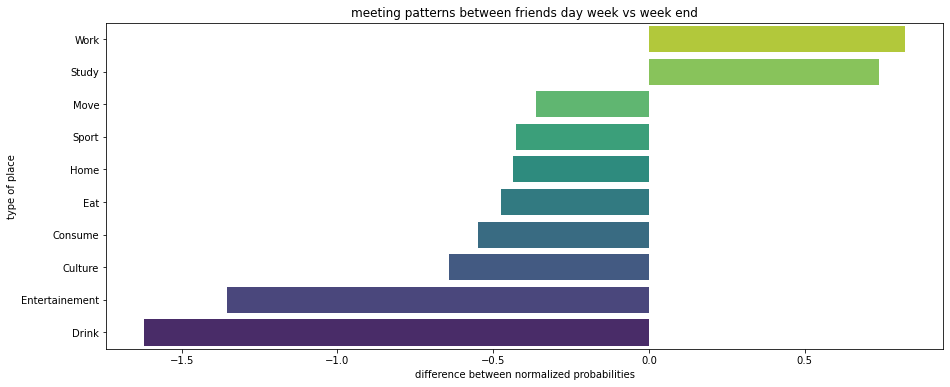

In [40]:
plt.figure(figsize=(15,6))
sns.barplot(x = df_places['numb_checkins'],y = df_places['place_type'], orient='h',\
            palette='viridis_r')
plt.xlabel('difference between normalized probabilities')
plt.ylabel('type of place')
plt.title('meeting patterns between friends day week vs week end')

- People tend to meet their friends more in work or study places during the week. This can be explained by the fact that people usually have their coworkers and classmates as friends on social media. Studying or working is part of people's obligations and these are task are generally proceeded during the week
- However, when it comes to free time (week end for most of people), people choose to meet their friends in diverting places (every other category that doesn't involve working or studying). Specifically, people are the most likely to go out in weekend to have drinks or to entertainement places.
- Finally, people tend to spend their day working and studying, and then spend their evening and night in diverting places (eating, having drinks)

### **ii) Times checkin patterns**

- In this final part, we will study the time friends meet.
We willclassify a day in two parts : day and night. 
- Since work usually finished at 5pm, we consider day hours of the day between 5h and 17h, and night as other hours of the day

In [41]:
#In order to get our times, we substract 4 from total checkin hours
#Then we get the hours that are superior to 14
df_classified.loc[:,'night'] = (df_classified.loc[:,'local_time'].dt.hour-5) > 12
df_classified.loc[:,'day'] = (df_classified.loc[:,'local_time'].dt.hour-5) <= 12

In [42]:
df_classified.head(2)

,day,local_time,place,country,dist_home,night
0,False,2012-05-05 19:24:41+00:00,Drink,US,161.0,True
1,True,2012-05-04 16:45:44+00:00,Move,US,18.0,False


In [43]:
# We groupby the place type and then get the ratio of evening checkins
df_classified=df_classified.groupby('place', as_index=False).\
                      agg({'night':'sum', 'country':'size', 'day':'sum'}).\
                      rename(columns={'country':'numb_checkins'})
df_classified['ratio_night'] = df_classified['night'] / sum(df_classified['numb_checkins'])
df_classified['ratio_day'] = df_classified['day'] / sum(df_classified['numb_checkins'])
#We sort values to have a good looking visualization
df_classified = df_classified.sort_values(by='ratio_day')

Text(0.5, 1.0, 'checkins in different times of day')

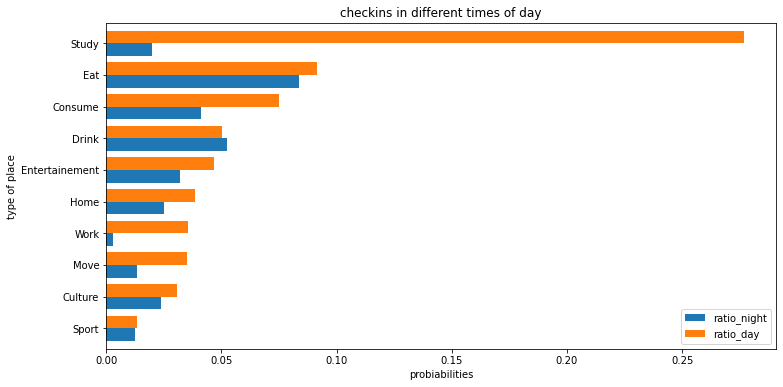

In [44]:
df_classified.plot(x='place', y=['ratio_night','ratio_day'], kind="barh", figsize=(12,6), width=0.8)

plt.xlabel('probiabilities')
plt.ylabel('type of place')
plt.title('checkins in different times of day')

- We first notice that :  
1) The biggest probability of checking in with friends during day occurs during studying  
2) The biggest probability of checking in with friends during night occurs during night.
- We now do the same work we did previously with the places patterns in order to compare the ratio of checkins:  
1) We get the difference between probabilities that a user checks in during the day or during night.
2) We divide the result by the probability of a checkin during the day
The final equation we will have is (for each place):
$$
final ratio = \frac{P_{daycheckin}-P_{nightcheckin}}{P_{daycheckin}}
$$

Text(0.5, 1.0, 'ratio of probabilities')

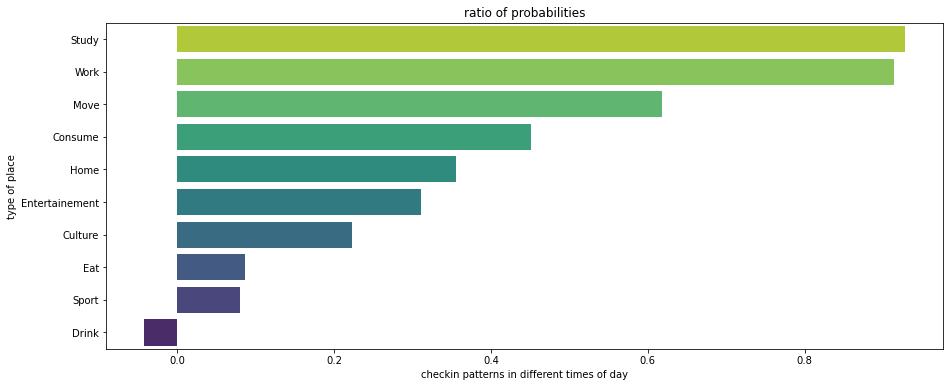

In [45]:
#get the ratio ( values used in the plot below)
df_classified['ratio_final'] = (df_classified['ratio_day'] - df_classified['ratio_night'])/\
                                df_classified['ratio_day']
plt.figure(figsize=(15, 6))
sns.barplot(x='ratio_final', y='place', data=df_classified.\
            sort_values(by='ratio_final', ascending=False), orient='h', palette='viridis_r')

plt.xlabel('checkin patterns in different times of day')
plt.ylabel('type of place')
plt.title('ratio of probabilities')

- We see that friends are more likely to meet during the day to study or work. Moreover, they are more likely to meet at night to have drinks, even if the difference is small. 
- We can conlude that most checkins happen to be during the day and that people tend less to checkin at night

### III) Conclusions :
- People tend to meet their friends more in work or study places during the week. This can be explained by the fact that people usually have their coworkers and classmates as friends on social media. Studying or working is part of people's obligations and these are task are generally proceeded during the week
- However, when it comes to free time (week end for most of people), people choose to meet their friends in diverting places (every other category that doesn't involve working or studying). Specifically, people are the most likely to go out in weekend to have drinks or to entertainement places.
- Finally, people tend to spend their day working and studying, and then spend their evening and night in diverting places (eating, having drinks)